# NLP with Disaster Tweets

## Detecting Disasters: Using BERT for NLP Separate Forest Fires from “Fire" Shoes

#### Alexander Bricken

---

### Project Goals:
- Explore typical data science and machine learning practices by doing the following:
    - Importing data
    - Exploring data
    - Cleaning data
    - Preparing data
    - Setting up a train-test split
    - Running a machine learning model
- Apply specific NLP data preparation techniques
    - Feature engineering by creating meta-features
    - Text cleaning in a simple way using tokenization
    - Text cleaning using specific word parsing
- Apply BERT, a state-of-the-art language model for NLP
    

### Table Of Contents

1. Import Libraries
2. Import Data
3. Data Exploration
4. Data Preparation
5. Calculating Meta-Features
6. Text Cleaning
7. Machine Learning
8. Preparing Kaggle Submission

---

### Import Libraries

In [106]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import feature_extraction, preprocessing, linear_model, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from pandas_profiling import ProfileReport
import scikitplot as skplt
import string
import random
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert

# seaborn settings
sns.set_theme(style="whitegrid")
np.random.seed(1)
torch.manual_seed(1)

### Import Data

In [2]:
raw_test_data = pd.read_csv("../data/raw/test.csv")
raw_train_data = pd.read_csv("../data/raw/train.csv")

In [3]:
raw_train_data

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

### Data Exploration

We use PandasProfiling, a convenient library for data exploration.

In [4]:
profile = ProfileReport(raw_train_data, title="Pandas Profiling Report")

In [5]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

By using Pandas Profiling we can check through some essential features of the dataset:
- Class distribution of target variable in the train dataset. This is a 4342 (0), 3271 (1) split. This near equal separation is ok for training our model.
- Missing data. We see that the `location` and `keyword` columns contain missing data. This will be handled below.
- Cardinality. Our `location` values are particularly distinct. This is also dicussed and handled below.

### Data Preparation

`location` and `keyword` contain null values, as demonstrated by the pandas profiling report.

In [6]:
foo = [(raw_train_data[['keyword', 'location']].isnull().sum().values, raw_test_data[['keyword', 'location']].isnull().sum().values)]
out = np.concatenate(foo).ravel()

In [7]:
null_counts = pd.DataFrame({"column": ['keyword', 'location', 'keyword', 'location'],
                           "label": ['train', 'train', 'test', 'test'],
                           "count": out})

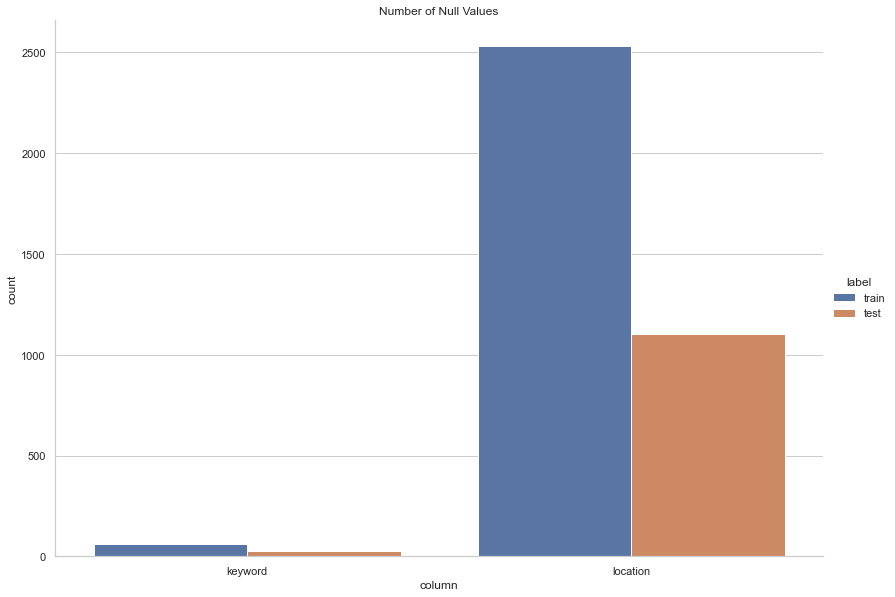

In [8]:
sns.catplot(x="column", y="count", data=null_counts, hue="label", kind="bar", height=8.27, aspect=11.7/8.27)
plt.title('Number of Null Values')
plt.show()

Locations from Twitter are user-populated and are thus too arbitrary. There are too many unique values and no standardization of input. We can remove this feature.

In [9]:
# drop location data
clean_train_data = raw_train_data.drop(columns="location")
clean_test_data = raw_test_data.drop(columns="location")

Keywords, on the other hand, are interesting to consider as a way of identifying disaster. This is because some keywords really are only used in a certain context.

What do our keywords look like? We can output wordclouds for our train and test datasets to examine this.

In [10]:
# set up stopwords (like the, and, but etc.)
stopwords = set(STOPWORDS)
stopwords.update(["nan"])

222 unique words in the keyword column for train data.


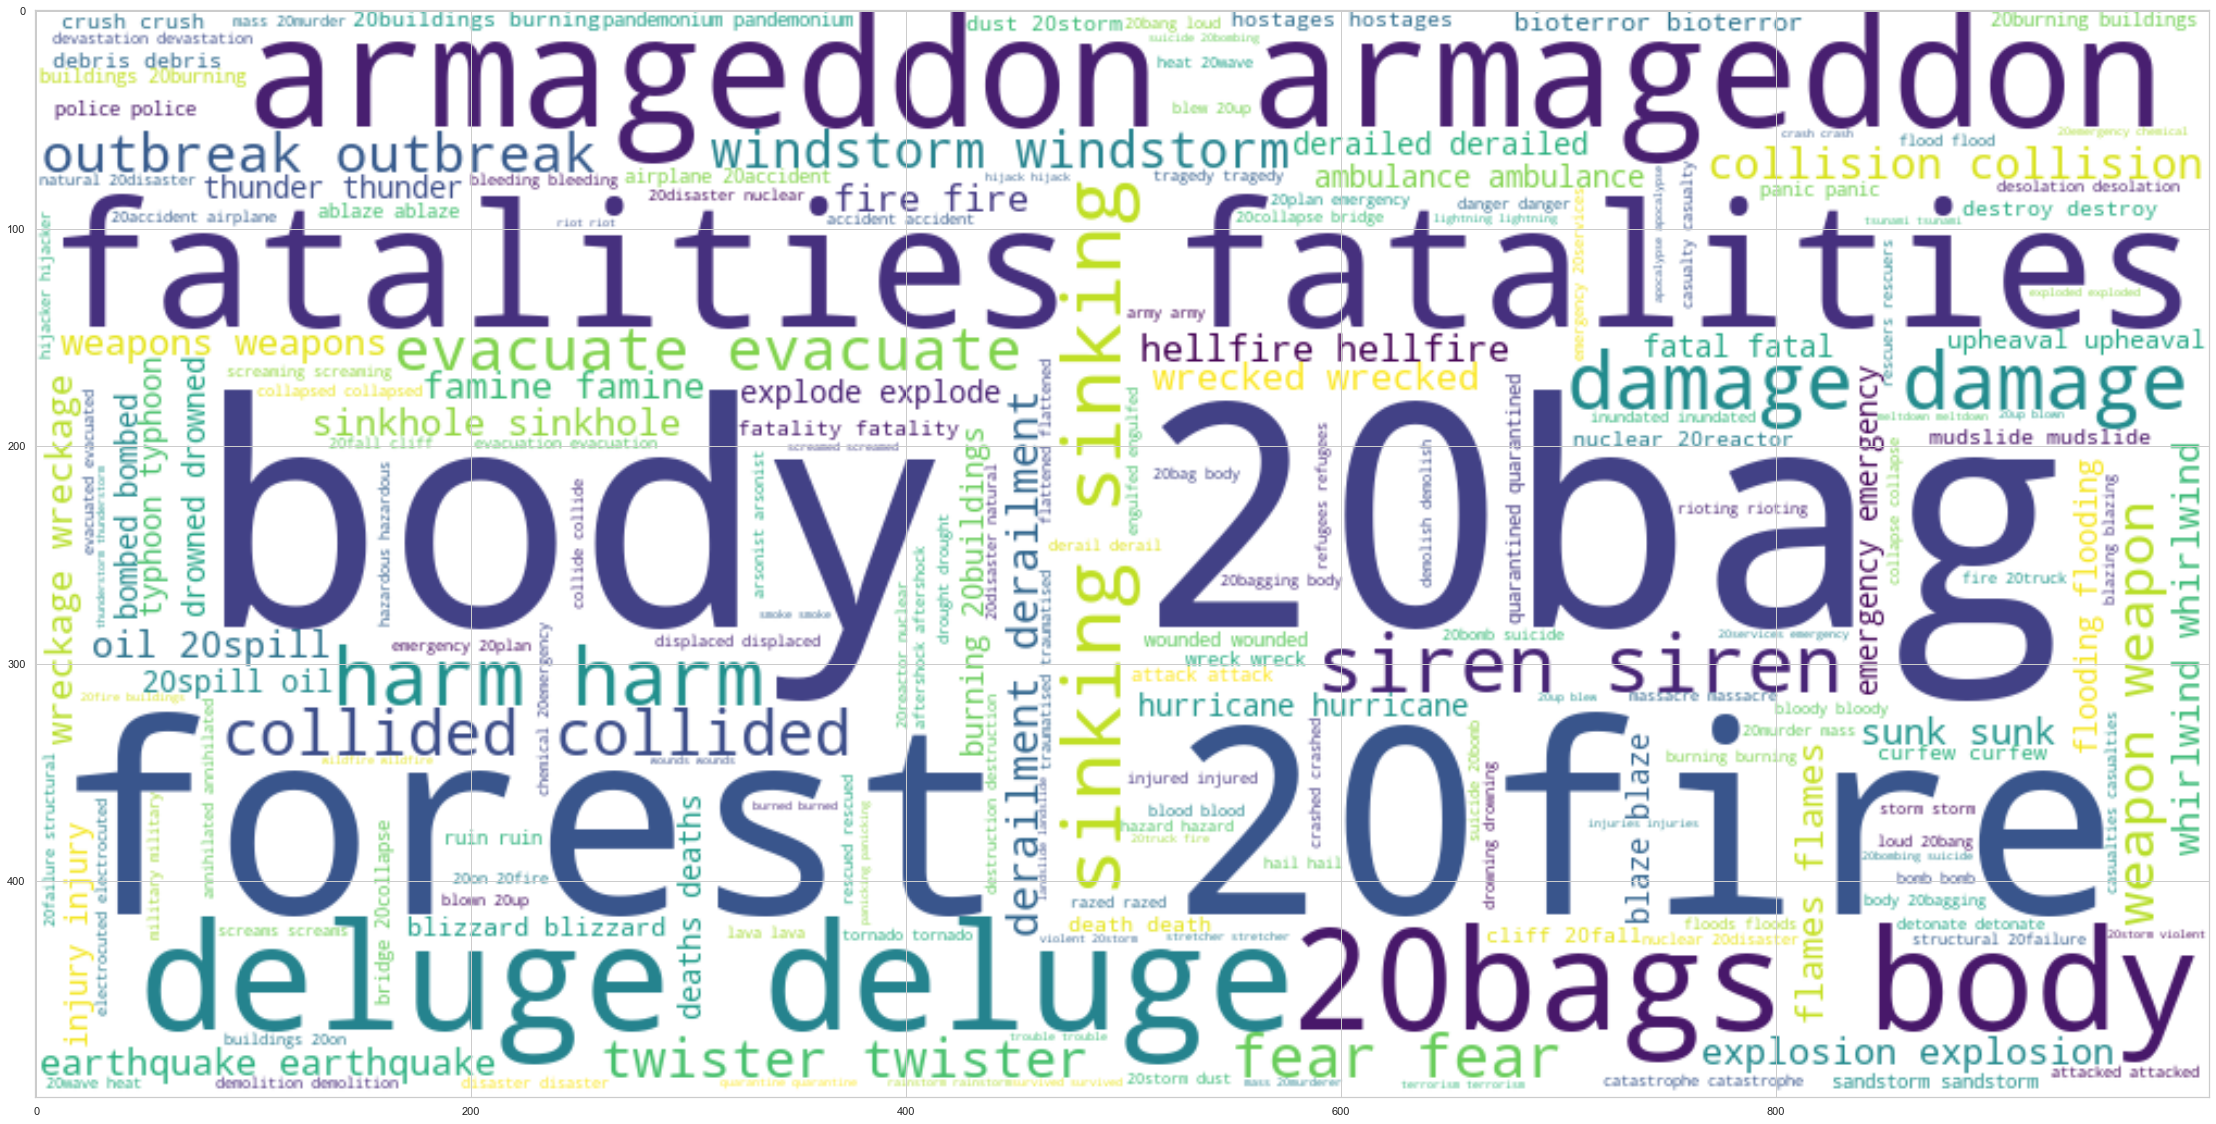

In [11]:
# for train
text = " ".join(word for word in clean_train_data['keyword'].astype(str))
print(f"{len(set(text.split()))} unique words in the keyword column for train data.")
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1000, height=500).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

222 unique words in the keyword column for test data.


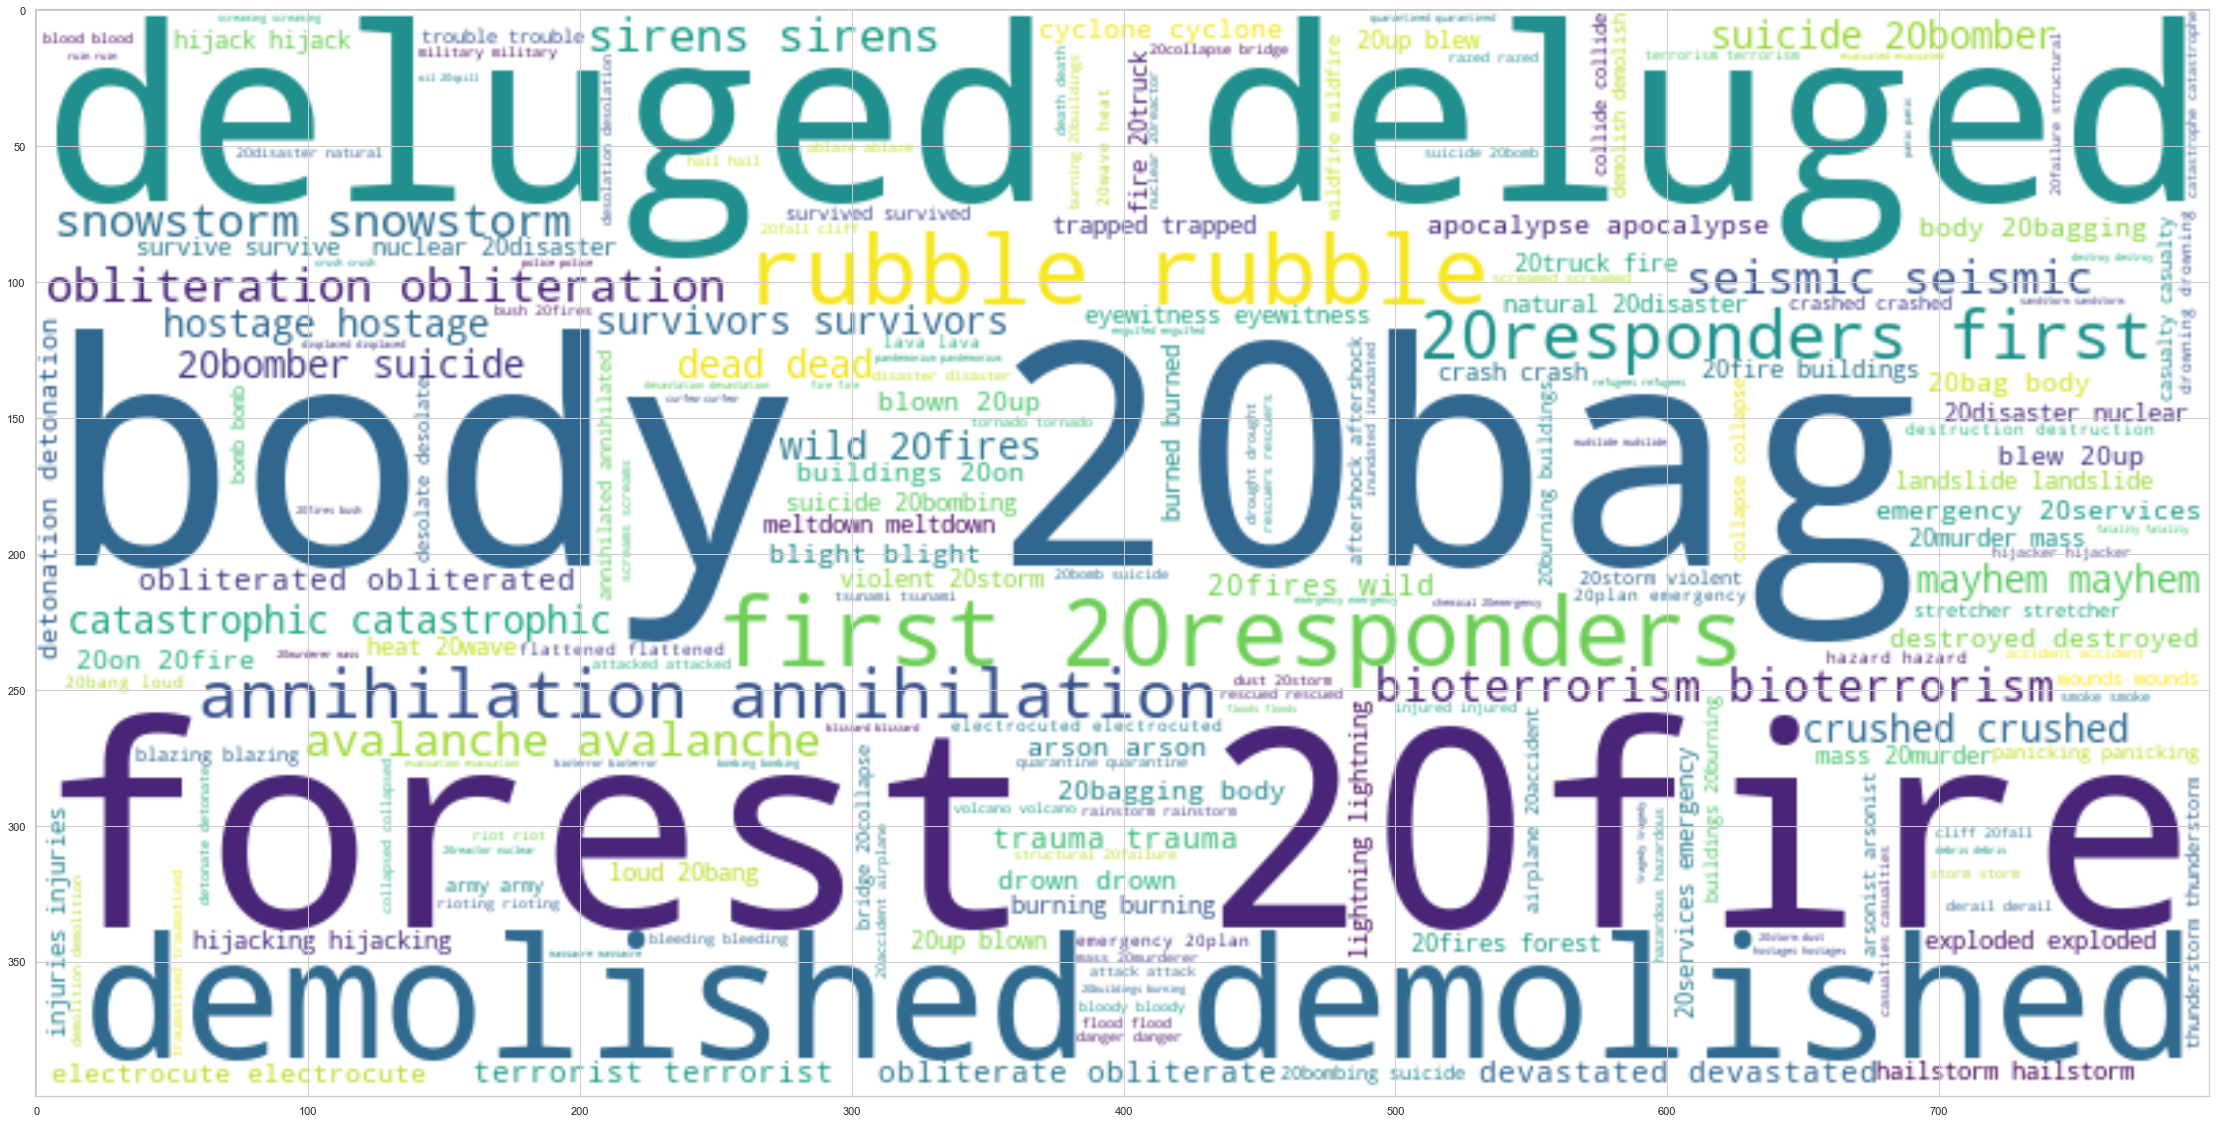

In [12]:
# for test
text = " ".join(word for word in clean_test_data['keyword'].astype(str))
print(f"{len(set(text.split()))} unique words in the keyword column for test data.")
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

We see that there is a good level of overlap between the keywords in treatment and control. Keyword is just one way of looking at the data, and if we just examine keywords there is not enough context to generate accurate predictions. The best way to use the keyword is to append each keyword to the end of Tweet. That way, we increase the weight of a keyword used, and thus don't need to drop or impute the null keyword columns (because those will just add nothing to the end).

In [13]:
# add keyword to end of text for train and test data
keyword_list_train = list(clean_train_data['keyword'])
keyword_list_test = list(clean_test_data['keyword'])
key_list_train = ['' if (type(i) == float and np.isnan(i)) else i for i in keyword_list_train]
key_list_test = ['' if (type(i) == float and np.isnan(i)) else i for i in keyword_list_test]
text_list_train = list(clean_train_data['text'])
text_list_test = list(clean_test_data['text'])

# iterate through and add to end, with space in-between
for i in range(len(clean_train_data['keyword'])):
    text_list_train[i] = text_list_train[i] + ' ' + key_list_train[i]

for i in range(len(clean_test_data['keyword'])):
    text_list_test[i] = text_list_test[i] + ' ' + key_list_test[i]

In [14]:
# relabel text
clean_train_data['text'] = text_list_train
clean_test_data['text'] = text_list_test

In [15]:
# drop keyword col
clean_train_data = clean_train_data.drop(columns='keyword')
clean_test_data = clean_test_data.drop(columns='keyword')

In [16]:
# output as check
clean_train_data.head()

id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4            Forest fire near La Ronge Sask. Canada        1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

Finally, it is worth checking for duplicates.

In [17]:
# check for duplicates using groupby
df_nondupes = clean_train_data.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_dupes = df_nondupes[df_nondupes['target'] > 1]
df_dupes.rename(columns={'id':'# of duplicates', 'target':'sum of target var'})

# of duplicates  \
text                                                                  
Hellfire is surrounded by desires so be careful...                3   
wowo--=== 12000 Nigerian refugees repatriated f...                2   
In #islam saving a person is equal in reward to...                2   
#foodscare #offers2go #NestleIndia slips into l...                3   
Who is bringing the tornadoes and floods. Who i...                3   
To fight bioterrorism sir. bioterrorism                           4   
#Allah describes piling up #wealth thinking it ...                3   
RT NotExplained: The only known image of infamo...                2   
Hellfire! We donÛªt even want to think about i...                2   
CLEARED:incident with injury:I-495  inner loop ...                3   
.POTUS #StrategicPatience is a strategy for #Ge...                4   
He came to a land which was engulfed in tribal ...                6   
The Prophet (peace be upon him) said 'Save your...                6   
that horrible sinking feeling when youÛªve bee...                4   
Caution: breathing may be hazardous to your hea...                2   

                                                    sum of target var  
text                                                                   
Hellfire is surrounded by desires so be careful...                  2  
wowo--=== 12000 Nigerian refugees repatriated f...                  2  
In #islam saving a person is equal in reward to...                  2  
#foodscare #offers2go #NestleIndia slips into l...                  2  
Who is bringing the tornadoes and floods. Who i...                  2  
To fight bioterrorism sir. bioterrorism                             2  
#Allah describes piling up #wealth thinking it ...                  2  
RT NotExplained: The only known image of infamo...                  2  
Hellfire! We donÛªt even want to think about i...                  2  
CLEARED:incident with injury:I-495  inner loop ...                  2  
.POTUS #StrategicPatience is a strategy for #Ge...                  2  
He came to a land which was engulfed in tribal ...                  2  
The Prophet (peace be upon him) said 'Save your...                  2  
that horrible sinking feeling when youÛªve bee...                  2  
Caution: breathing may be hazardous to your hea...                  2

If we iterate through these duplicates we can individually label them by hand so we keep the data. 
This is necessary because some of them are mislabeled as well as being duplicate. For example, there are three duplicates of the first row, but 2 of them have the target label 1, and one of them has target label 0. This is seen throughout the table via the difference in the the `# of duplicates` against the `sum of target var`, as seen above.

In [18]:
# take index which is the texts themselves
dupe_text_list = df_dupes.index
dupe_text_list = list(dupe_text_list) # turn into list

# manually make label list to iterate
right_labels = [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]

In [19]:
# drop duplicates except for one
clean_train_data = clean_train_data.drop_duplicates(subset=['text'], keep='last').reset_index(drop=True)

In [20]:
# relabel duplicate rows
for i in range(len(dupe_text_list)):
    clean_train_data.loc[clean_train_data['text'] == dupe_text_list[i], 'target'] = right_labels[i]

### Calculating Meta-Features

We need ways to learn more about our data and separate it out into additional features. By thinking about different variables we can generate that might help us distinguish disasters from non-disasters, we can train our model on more features. This will provide more visibility for our model. The best way to think about Tweets indicating disaster are that they are likely from higher quality sources that are more serious in nature. Thus, following stricter grammatical rules, fully reporting on the situation, and sharing links (taken from https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert).

- `num_hashtags` count of hashtags (#) (hypothesis (H): hashtags are used by normal users rather than new agencies)
- `num_mentions` count of mentions (@) (H: more tags could be used by normal users rather than news agencies)
- `num_words` count of words (H: more words in proper reports on Twitter than normal user tweets)
- `num_stop_words` number of stop words (H: more stop words used via proper grammar from news agencies)
- `num_urls` count of urls (H: urls shared by news agencies reporting disaster more often than not)
- `avg_word_length` average character count in words (H: longer words that aren't abbreviated used by news agencies)
- `num_chars` count of characters (H: more characters used in news agency tweets to report full story)
- `num_punctuation` count of punctuations (H: more punctuation in news agency tweets following correct grammar)

We generate these new columns below.

In [21]:
### num_hashtags
clean_train_data['num_hashtags'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
clean_test_data['num_hashtags'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

### num_mentions
clean_train_data['num_mentions'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
clean_test_data['num_mentions'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

### num_words
clean_train_data['num_words'] = clean_train_data['text'].apply(lambda x: len(str(x).split()))
clean_test_data['num_words'] = clean_test_data['text'].apply(lambda x: len(str(x).split()))

### num_stop_words
clean_train_data['num_stop_words'] = clean_train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
clean_test_data['num_stop_words'] = clean_test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

### num_urls
clean_train_data['num_urls'] = clean_train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
clean_test_data['num_urls'] = clean_test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

### avg_word_length
clean_train_data['avg_word_length'] = clean_train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_test_data['avg_word_length'] = clean_test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

### num_chars
clean_train_data['num_chars'] = clean_train_data['text'].apply(lambda x: len(str(x)))
clean_test_data['num_chars'] = clean_test_data['text'].apply(lambda x: len(str(x)))

### num_punctuation
clean_train_data['num_punctuation'] = clean_train_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
clean_test_data['num_punctuation'] = clean_test_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

### Text Cleaning

We need to make sure the tweets we are using in our dataset are in a similar fashion. Particularly in the user-created Tweets, there could be plenty of typos, missing grammar, or abbreviations.

In [22]:
# copy over to save
train_df = clean_train_data.copy()
test_df = clean_test_data.copy()

In [23]:
# function taken from https://towardsdatascience.com/cleaning-text-data-with-python-b69b47b97b76

def simple_text_clean(x):
    # first we lowercase everything
    x = x.lower()
    # then remove stop words (all encoded in meta features)
    x = ' '.join([word for word in x.split(' ') if word not in stopwords])
    # then remove unicode characters
    x = x.encode('ascii', 'ignore').decode()
    # then use regex to remove mentions, hashtags, and links (all of this is encoded in meta features)
    x = re.sub(r'https*\S+', ' ', x)
    x = re.sub(r'http*\S+', ' ', x)
    x = re.sub(r'@\S+', ' ', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
    return x

In [24]:
train_df['cleaned_text'] = train_df.text.apply(simple_text_clean)
test_df['cleaned_text'] = test_df.text.apply(simple_text_clean)

### Tokenization

I perform tokenization here as a basic way of including the data of my text into the machine learning model alongside my meta-features.

Tokenization separates a piece of text into tokens. These tokens are words. It allows the text data to be turned into numbers that the machine learning model can read. We use a vocabulary size of 10000 here to make it extremely broad to start with. Eventually, we may want to lower this to deal with OOV (Out Of Vocabulary) words more appropriately.

**Separating text and non-text columns for tokenization:**

In [25]:
# create final dfs without text col
final_train_df = train_df.drop(columns=['text', 'id'])
final_test_df = test_df.drop(columns=['text', 'id'])

In [26]:
# separate clean text
train_text = final_train_df['cleaned_text']
test_text = final_test_df['cleaned_text']
# from no text
train_no_text_df = final_train_df.drop(columns='cleaned_text')
test_no_text_df = final_test_df.drop(columns='cleaned_text')

**For Text column, we need to tokenise using BertTokenizer:**

In [27]:
# we use a pre-trained bert model to tokenize the text
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

To start with, because BERT works with fixed-length sequences, we need to choose the maximum length of the sequences to best represent the model. By storing the length of each Tweet, we can do this and evaluate the coverage.

In [32]:
token_lens = []
for txt in list(train_text):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

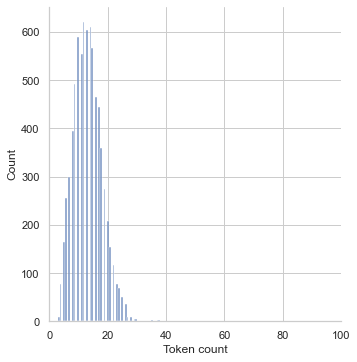

In [41]:
sns.displot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')
plt.show()

From this plot, we see the density drops off beyond 40. To be safe, we se the max length to 42.

In [48]:
def bert_tokenizer(text):
    encoding = tokenizer.encode_plus(
    text,
    max_length=42,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
    )
    return encoding['input_ids'][0], encoding['attention_mask'][0]

In [49]:
# train data tokenization
train_tokenized_list = []
train_attn_mask_list = []
for text in list(train_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    train_tokenized_list.append(tokenized_text.numpy())
    train_attn_mask_list.append(attn_mask.numpy())

In [50]:
# test data tokenization
test_tokenized_list = []
test_attn_mask_list = []
for text in list(test_text):
    tokenized_text, attn_mask = bert_tokenizer(text)
    test_tokenized_list.append(tokenized_text.numpy())
    test_attn_mask_list.append(attn_mask.numpy())

In [51]:
train_tokenised_text_df = pd.DataFrame(train_tokenized_list)
test_tokenised_text_df = pd.DataFrame(test_tokenized_list)

In [52]:
train_tokenised_text_df

0      1      2      3      4     5      6      7      8      9   ...  \
0     101  15616   3114   2089  16455  9641   2149    102      0      0  ...   
1     101   3224   2543   2379   2474  6902   3351  21871   2243   2710  ...   
2     101   3901   2356   2173  19488  3738  13982   7713   2173   4449  ...   
3     101   2111   4374  13982   4449  2662    102      0      0      0  ...   
4     101   2288   2741   6302  10090  5610  10364   2015   2082    102  ...   
...   ...    ...    ...    ...    ...   ...    ...    ...    ...    ...  ...   
7521  101   2048   5016  27083   3173  2958   7859   3518   5014    102  ...   
7522  101   2491   3748   8769   2662  2130   2642   2112   2110  19817  ...   
7523  101  11396  12779   7359    102     0      0      0      0      0  ...   
7524  101   2610  11538   7997  17745  2482   2210   5978   7997   7945  ...   
7525  101   6745   5014  10958   5422  2642   2662   3748  10273   5925  ...   

      32  33  34  35  36  37  38  39  40  41  
0      0   0   0   0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0   0   0   0  
4      0   0   0   0   0   0   0   0   0   0  
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
7521   0   0   0   0   0   0   0   0   0   0  
7522   0   0   0   0   0   0   0   0   0   0  
7523   0   0   0   0   0   0   0   0   0   0  
7524   0   0   0   0   0   0   0   0   0   0  
7525   0   0   0   0   0   0   0   0   0   0  

[7526 rows x 42 columns]

In [120]:
test_tokenised_text_df

0      1      2      3      4      5      6      7      8     9   ...  \
0     101   3047   6659   2482   5823    102      0      0      0     0  ...   
1     101   2657   2367   3655   2994   3647   3071    102      0     0  ...   
2     101   3224   2543   3962   8644  28519  14070   2408   2395  3828  ...   
3     101  16976   7497    102      0      0      0      0      0     0  ...   
4     101  15393   2061  12672  10626   8563   2859   6629    102     0  ...   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...   ...  ...   
3258  101   8372   3808   3050   3349   3808   3435  24454   2015  1060  ...   
3259  101   4040  15544   4788   2197   7064   2103  23713  18263  2718  ...   
3260  101   2665   2240   4315  12502   3672   3190    102      0     0  ...   
3261  101  12669   3314  17760   4633  17680   1044  12155    102     0  ...   
3262  101   8878   4546   5057   2933    102      0      0      0     0  ...   

      32  33  34  35  36  37  38  39  40  41  
0      0   0   0   0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0   0   0   0  
4      0   0   0   0   0   0   0   0   0   0  
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
3258   0   0   0   0   0   0   0   0   0   0  
3259   0   0   0   0   0   0   0   0   0   0  
3260   0   0   0   0   0   0   0   0   0   0  
3261   0   0   0   0   0   0   0   0   0   0  
3262   0   0   0   0   0   0   0   0   0   0  

[3263 rows x 42 columns]

**Non-text data: final expansion of metafeatures using one-hot encoding to make them less revelant in model.**

In order to incorporate our metafeatures into our modelling, we need to introduce them to a neural network after out BERT modelling. This is because they won't be interpreted correctly otherwise. We can prepare them here by simply normalising using `MinMaxScaler()`.

In [53]:
# take features with no text
features = test_no_text_df.columns

In [54]:
# normalise columns
scaler = MinMaxScaler()
train_no_text_df[features] = scaler.fit_transform(train_no_text_df[features])
test_no_text_df[features] = scaler.fit_transform(test_no_text_df[features])

In [70]:
# text labels
train_labels = train_no_text_df['target']

In [72]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(train_tokenised_text_df, train_labels, test_size=0.3, random_state=42)

### Machine Learning with Keras

In [61]:
class TweetClassifier(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        
        super(TweetClassifier, self).__init__(name=name)
        
        bias_initializer = tf.keras.initializers.HeNormal()
        
        self.embedding = Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu",
                                        bias_initializer=bias_initializer)
        self.cnn_layer2 = Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu",
                                        bias_initializer=bias_initializer)
        self.cnn_layer3 = Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu",
                                        bias_initializer=bias_initializer)
        self.pool = GlobalMaxPool1D()
        
        self.dense_1 = Dense(units=dnn_units, activation="relu", bias_initializer=bias_initializer)
        self.dropout = Dropout(rate=dropout_rate)

        self.last_dense = Dense(units=1, activation="sigmoid")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [83]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 10

In [84]:
text_model = TweetClassifier(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [93]:
text_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [94]:
history = text_model.fit(X_train, y_train, epochs=NB_EPOCHS, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
165/165 [==============================] - 10s 59ms/step - loss: 0.0000e+00 - accuracy: 0.5802 - val_loss: 0.0000e+00 - val_accuracy: 0.5793
Epoch 2/10
165/165 [==============================] - 9s 56ms/step - loss: 0.0000e+00 - accuracy: 0.5729 - val_loss: 0.0000e+00 - val_accuracy: 0.5793
Epoch 3/10
165/165 [==============================] - 10s 60ms/step - loss: 0.0000e+00 - accuracy: 0.5750 - val_loss: 0.0000e+00 - val_accuracy: 0.5793
Epoch 4/10
165/165 [==============================] - 9s 56ms/step - loss: 0.0000e+00 - accuracy: 0.5669 - val_loss: 0.0000e+00 - val_accuracy: 0.5793
Epoch 5/10
165/165 [==============================] - 10s 61ms/step - loss: 0.0000e+00 - accuracy: 0.5668 - val_loss: 0.0000e+00 - val_accuracy: 0.5793
Epoch 6/10
165/165 [==============================] - 10s 61ms/step - loss: 0.0000e+00 - accuracy: 0.5648 - val_loss: 0.0000e+00 - val_accuracy: 0.5793
Epoch 7/10
165/165 [==============================] - 10s 61ms/step - loss: 0.0000e+00 - a

In [87]:
results = text_model.evaluate(X_test)
print(results)

71/71 [==============================] - 0s 764us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


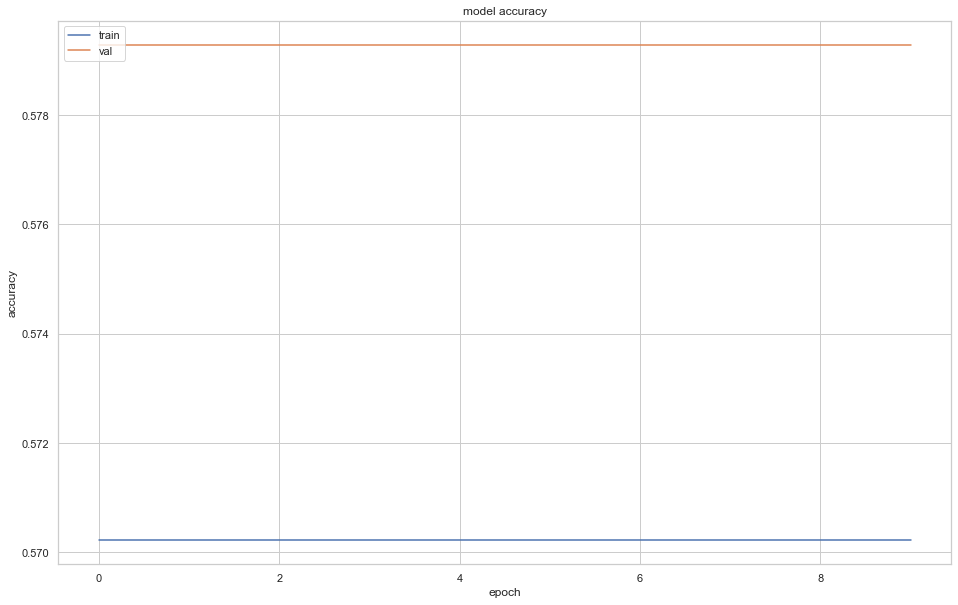

In [95]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

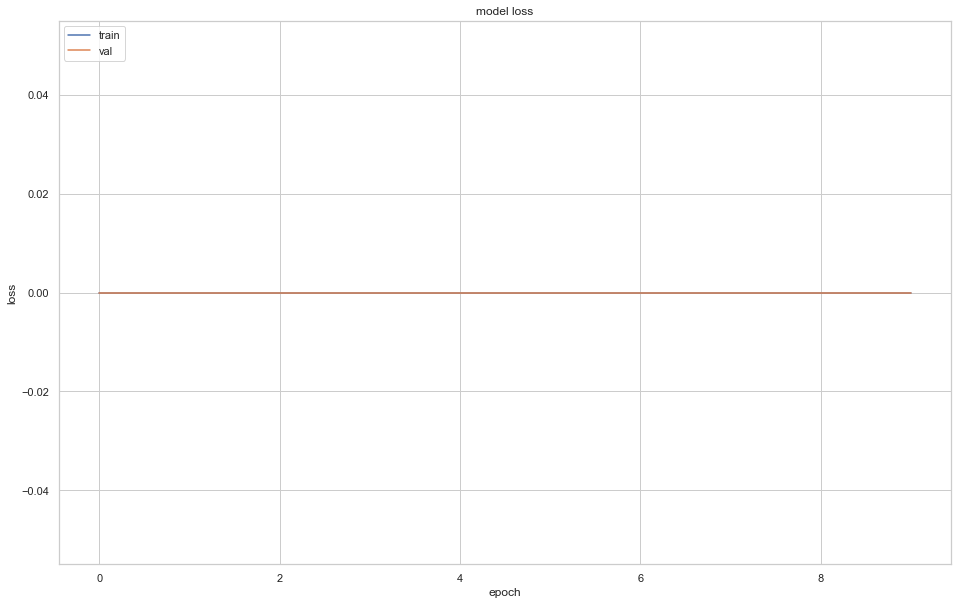

In [97]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Basic Machine Learning Using Tokenization

In [102]:
# create generic CNN
# i will modify the layers of this later
model_conv = tf.keras.Sequential([
    Embedding(VOCAB_LENGTH, EMB_DIM, input_length=42),
    Dropout(0.2),
    Conv1D(128, 7, activation='relu'),
    GlobalMaxPool1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# compile and summarise
model_conv.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_conv.summary()

# first fit is history1
history1 = model_conv.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 42, 200)           6104400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 42, 200)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 36, 128)           179328    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [113]:
# predictions
test_pred = model_conv.predict(train_tokenised_text_df)
print(test_pred)
# this is the probabilities of each row being not disastrous (0) or disaster (1)

[[0.02200517]
 [0.99956733]
 [0.9943291 ]
 ...
 [0.99574804]
 [0.9972451 ]
 [0.99999344]]


In [114]:
len(test_pred)

7526

### Preparing Kaggle Submission

All we need to do now is turn our output probabilities of our machine learning model into boolean values and submit the predictions!

In [115]:
# this checks if the probability of disaster is above 0.5. If so, we label 1.
test_pred_bool = test_pred.copy().astype(int)
for index in range(len(test_pred)): 
    if test_pred[index]>0.5:
        test_pred_bool[index]=1
    else:
        test_pred_bool[index]=0

In [116]:
final_predictions = test_pred_bool.flatten()

In [119]:
accuracy_score(test_tokenised_text_df, final_predictions)

ValueError: Found input variables with inconsistent numbers of samples: [3263, 7526]

In [109]:
submission = pd.read_csv("../data/submissions/submission.csv")

In [110]:
submission["target"] = final_predictions

ValueError: Length of values (2258) does not match length of index (3263)

In [43]:
submission.to_csv('submission1.csv', index=False)

In [44]:
submission

id  target
0         0       1
1         2       1
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       1

[3263 rows x 2 columns]

To submit, we use the Kaggle API and type the following:

`kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"`

#### BERT Modelling (to be further explored soon)

In [173]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)

In [174]:
def build_model(bert_layer, max_seq_len, lr):
        
    input_word_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_seq_len,), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name='segment_ids')    

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])   
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    optimizer = SGD(learning_rate=lr, momentum=0.8)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
all_tokens = []
all_masks = []
all_segments = []

for text in texts:
    text = self.tokenizer.tokenize(text)
    text = text[:self.max_seq_length - 2]
    input_sequence = ['[CLS]'] + text + ['[SEP]']
    pad_len = self.max_seq_length - len(input_sequence)

    tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
    tokens += [0] * pad_len
    pad_masks = [1] * len(input_sequence) + [0] * pad_len
    segment_ids = [0] * self.max_seq_length

    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(segment_ids)

return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
X_trn_encoded = self.encode(X.loc[trn_idx, 'text_cleaned'].str.lower())
y_trn = X.loc[trn_idx, 'target_relabeled']
X_val_encoded = self.encode(X.loc[val_idx, 'text_cleaned'].str.lower())
y_val = X.loc[val_idx, 'target_relabeled']

In [181]:
# Model
model = build_model(bert_layer, max_seq_len=128, lr=0.0001)        
model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val), callbacks=[metrics], epochs=10, batch_size=32)

NameError: name 'X_trn_encoded' is not defined

In [156]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_layer(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * ['this is such an amazing movie!']
    * False
    * None
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'), 'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), 'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids')}
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * {'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_mask'), 'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/input_word_ids')}
    * True
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * {'input_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids'), 'input_word_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), 'input_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask')}
    * False
    * None
  Keyword arguments: {}

#### Additional Machine Learning Tests

In [181]:
# testing a support vector machine

# because I haven't done any NLP, I will just use random data with my labels.

y_true = clean_train_data['target']
x1 = np.random.random_sample(len(y_true))
x2 = np.random.random_sample(len(y_true))
xs = list(zip(x1,x2))

In [182]:
X_train, X_test, y_train, y_test = train_test_split(xs, y_true, test_size=0.3, random_state=42)

In [183]:
clf = SVC(probability=True)
clf.fit(X_train, y_train)

SVC(probability=True)

In [184]:
y_pred = clf.predict(X_test)
y_probas = clf.predict_proba(X_test)

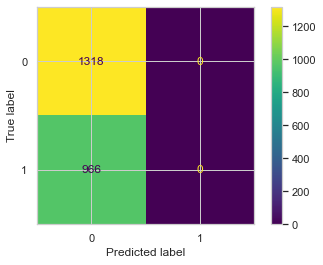

In [185]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()  

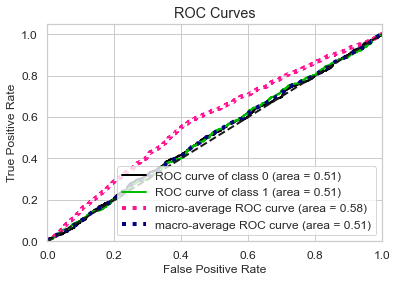

In [186]:
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [187]:
print(classification_report(y_test, y_pred, target_names=["not disaster", "disaster"]))

              precision    recall  f1-score   support

not disaster       0.58      1.00      0.73      1318
    disaster       0.00      0.00      0.00       966

    accuracy                           0.58      2284
   macro avg       0.29      0.50      0.37      2284
weighted avg       0.33      0.58      0.42      2284



/usr/local/Caskroom/miniconda/base/envs/pygen/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/pygen/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniconda/base/envs/pygen/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

### Other tokenization way

In [51]:
# tokenization of train texts
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [52]:
# tokenization of test texts
test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [53]:
train_padded_val_df = pd.DataFrame(train_padded)
test_padded_val_df = pd.DataFrame(test_padded)

# add to df
tokenized_train_df = pd.concat([train_no_text_df, train_padded_val_df], axis=1, join="inner")
tokenized_test_df = pd.concat([test_no_text_df, test_padded_val_df], axis=1, join="inner")

In [54]:
tokenized_train_df

target  num_hashtags  num_mentions  num_words  num_stop_words  num_urls  \
0          1      0.076923          0.00   0.387097        0.315789      0.00   
1          1      0.000000          0.00   0.193548        0.000000      0.00   
2          1      0.000000          0.00   0.677419        0.578947      0.00   
3          1      0.076923          0.00   0.225806        0.052632      0.00   
4          1      0.153846          0.00   0.483871        0.368421      0.00   
...      ...           ...           ...        ...             ...       ...   
7521       1      0.000000          0.00   0.322581        0.105263      0.25   
7522       1      0.000000          0.25   0.612903        0.473684      0.00   
7523       1      0.000000          0.00   0.225806        0.052632      0.25   
7524       1      0.000000          0.00   0.580645        0.263158      0.00   
7525       1      0.000000          0.00   0.387097        0.157895      0.25   

      avg_word_length  num_chars  num_punctuation  0  ...    90    91    92  \
0            0.119201   0.393548         0.016393  0  ...     0     0     0   
1            0.131679   0.193548         0.016393  0  ...     0     0     0   
2            0.166378   0.806452         0.049180  0  ...  1490  1370   560   
3            0.302242   0.367742         0.032787  0  ...     0     0     0   
4            0.126908   0.516129         0.032787  0  ...     0     0     0   
...               ...        ...              ... ..  ...   ...   ...   ...   
7521         0.269604   0.483871         0.081967  0  ...     0     0    47   
7522         0.180344   0.754839         0.081967  0  ...     0   669    97   
7523         0.310592   0.367742         0.180328  0  ...     0     0     0   
7524         0.244677   0.832258         0.081967  0  ...   315  4627  1988   
7525         0.247651   0.554839         0.114754  0  ...     0     0   257   

        93    94    95    96    97    98    99  
0        0  3986   683    68  2516  3987    31  
1       32     3   284   655  5808  5809  1179  
2     5810  1491    71  1842   560  1180   894  
3        0     0    13  3988    71  1180    36  
4       33  1003   368  5811    81  5812   197  
...    ...   ...   ...   ...   ...   ...   ...  
7521   677  1153   878   128    39   538   251  
7522    44    36   208   227   413   301  5785  
7523     0     0     0     0  1361   282  1362  
7524  2124  3511  1020  1062    63  1749   116  
7525   251   196   227    36    54   623    27  

[7526 rows x 109 columns]

In [55]:
tokenized_test_df

num_hashtags  num_mentions  num_words  num_stop_words  num_urls  \
0         0.000000           0.0   0.161290        0.111111      0.00   
1         0.083333           0.0   0.258065        0.111111      0.00   
2         0.000000           0.0   0.580645        0.555556      0.00   
3         0.166667           0.0   0.096774        0.000000      0.00   
4         0.000000           0.0   0.225806        0.111111      0.00   
...            ...           ...        ...             ...       ...   
3258      0.000000           0.0   0.225806        0.000000      0.00   
3259      0.000000           0.0   0.709677        0.388889      0.00   
3260      0.000000           0.0   0.161290        0.055556      0.25   
3261      0.000000           0.0   0.193548        0.000000      0.25   
3262      0.166667           0.0   0.225806        0.111111      0.00   

      avg_word_length  num_chars  num_punctuation  0  1  ...  90    91   92  \
0            0.176301   0.160494         0.000000  0  0  ...   0     0    0   
1            0.296724   0.345679         0.054545  0  0  ...   0     0    0   
2            0.113173   0.543210         0.036364  0  0  ...   0    32    3   
3            0.559249   0.197531         0.054545  0  0  ...   0     0    0   
4            0.169075   0.228395         0.000000  0  0  ...   0     0    0   
...               ...        ...              ... .. ..  ...  ..   ...  ...   
3258         0.277457   0.290123         0.000000  0  0  ...   0     0    0   
3259         0.198291   0.808642         0.090909  0  0  ...   2  6823  288   
3260         0.479769   0.290123         0.090909  0  0  ...   0     0    0   
3261         0.488026   0.351852         0.127273  0  0  ...   0     0    0   
3262         0.418353   0.370370         0.054545  0  0  ...   0     0    0   

        93    94    95    96    97    98    99  
0        0     0     0   718  1655    60    20  
1        0   409   986  2287   483  1759   274  
2      648  3071     1  4415   684   577   424  
3        0     0     0     0     0   218  3406  
4        0     0    55   556   410   471  1166  
...    ...   ...   ...   ...   ...   ...   ...  
3258   179   950  2526  2527   950     1     1  
3259  6824   325   123   364    25   311   415  
3260     0     0     0   766   536   193   756  
3261     0  5381   478   213   316  1489  1635  
3262     0     0     0  2447  1363     4   312  

[3263 rows x 108 columns]